# Imports and Data Loading

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

leak_data_raw =  pd.read_csv("Gasleak Data Sets/sensor_readings.csv")
leak_data_raw.columns = ["temp","Time","Sensor 1", "Sensor 2", "Sensor 3", "Sensor 4", "Sensor 5", "Sensor 6", "Sensor 7", "Sensor 8", "Sensor 9", "Sensor 10", "Sensor 11", "Sensor 12", "Sensor 13", "Sensor 14", "Sensor 15", "Sensor 16", "Sensor 17", "Sensor 18", "Sensor 19", "Sensor 20", "Sensor 21", "Sensor 22", "Sensor 23", "Sensor 24"]

weather_df = pd.read_csv("Gasleak Data Sets/weather_data.csv")
columns_to_average = ['Barometric_Pressure', 'Humidity', 'Temperature', 'Wind_Direction', 'Wind_Speed']
for col in columns_to_average:
    weather_df[col] = weather_df.groupby('timestamp')[col].transform('mean')
weather_df = weather_df.drop_duplicates()
weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp']).astype(int) // 10**9
weather_df = weather_df.rename(columns={'timestamp': 'tTime'})

leak_rate_df = pd.read_csv("Gasleak Data Sets/leak_locations_and_rate.csv")
leak_rate_df =  leak_rate_df[['LeakRate', 'tStart', 'tEnd', 'Duration']]
leak_rate_df['LeakRate'] = leak_rate_df.groupby('tStart')['LeakRate'].transform('mean')
leak_rate_df = leak_rate_df.drop_duplicates()


/var/folders/qt/r87857tx74n48x9wj7f9wljw0000gn/T/ipykernel_1004/3743120713.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp']).astype(int) // 10**9


# Merging Data Sets

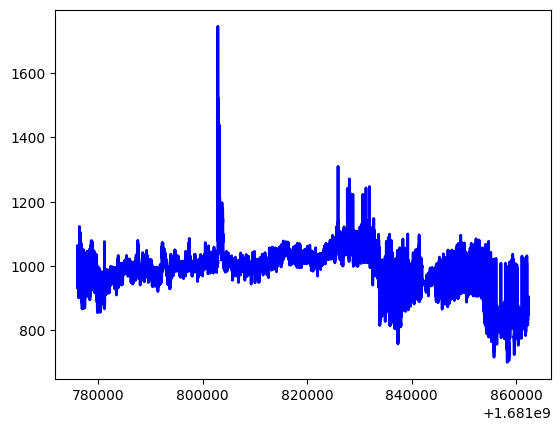

In [90]:
df = leak_data_raw.drop(['temp'], axis=1)
plt.plot(df['Time'], df['Sensor 1'], linewidth=2, linestyle="-", c="b")  # smooth by filter


Data is very noisy, must filter

In [96]:
leak_data = df.copy()
leak_data['Average'] = leak_data.iloc[:,1:].mean(axis=1)
leak_data['Total'] = leak_data.iloc[:,1:].sum(axis=1)
leak_data['Time'] -= 1681776002
leak_data.head()

,Time,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,Sensor 6,Sensor 7,Sensor 8,Sensor 9,...,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Sensor 22,Sensor 23,Sensor 24,Average,Total
0,0,1030.0,1049.0,1166.0,964.0,1023.0,1090.5,1039.5,1153.0,1082.0,...,1088.0,991.5,931.0,1040.0,1040.0,1111.0,1080.0,1089.0,1050.187500,26254.687500
1,1,1033.0,1051.0,1163.0,974.0,993.0,1095.0,1044.0,1152.0,1085.0,...,1090.0,984.0,928.5,1043.0,1052.0,1105.5,1075.0,1095.0,1049.416667,26235.416667
2,2,1022.0,1051.0,1160.0,975.5,974.0,1081.0,1049.0,1133.0,1088.0,...,1095.0,993.0,926.0,1039.0,1033.0,1100.0,1021.0,1093.0,1045.083333,26127.083333
3,3,1034.0,1050.0,1165.0,977.0,988.0,1084.0,1019.0,1128.0,1091.0,...,1100.0,999.0,929.0,1047.5,1014.0,1107.0,1059.5,1110.0,1048.854167,26221.354167
4,4,1037.5,1049.0,1155.0,977.0,971.0,1084.0,1027.0,1144.0,1090.5,...,1100.0,1004.5,944.0,1056.0,1019.0,1098.0,1098.0,1107.5,1049.000000,26225.000000


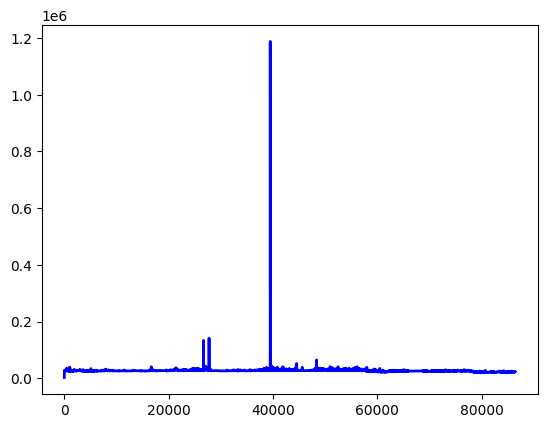

In [97]:
leak_data['Total'] = pd.DataFrame(lfilter([1.0 / 10] * 10, 1, leak_data['Total']))
plt.plot(leak_data['Time'], leak_data['Total'], linewidth=2, linestyle="-", c="b")  # smooth by filter

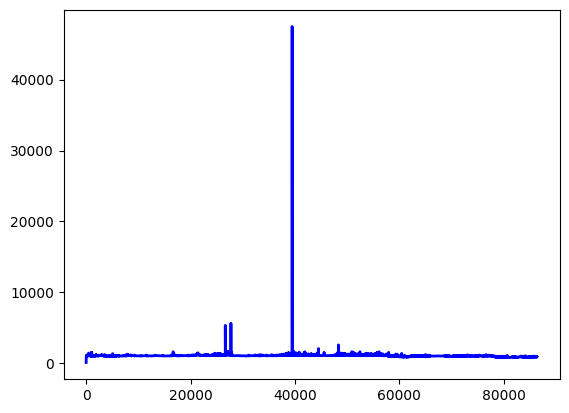

In [98]:
leak_data['Average'] = pd.DataFrame(lfilter([1.0 / 10] * 10, 1, leak_data['Average']))
plt.plot(leak_data['Time'], leak_data['Average'], linewidth=2, linestyle="-", c="b")  # smooth by filter

Both Average and Totals are very Similar in Shape (Uniform w/ some peaks), but average numbers are smaller

# Train Model

In [99]:
# Imports
import torch

import lightning as L
from torch.utils.data import TensorDataset, DataLoader
import model as m


model = m.LightningLSTM()

In [102]:
normalized_sensor_average = (leak_data['Average'] - leak_data['Average'].min()) / (leak_data['Average'].max() - leak_data['Average'].min())
normalized_sensor_average = normalized_sensor_average.astype(dtype='float32')

In [103]:
window_size = 60

# Create a list of input sequences
inputs = [normalized_sensor_average.iloc[i:i+window_size].values for i in range(len(normalized_sensor_average) - window_size)]

# Create a list of corresponding labels
labels = normalized_sensor_average.iloc[window_size:].values

inputs = torch.tensor(np.array(inputs), dtype=torch.float32) # convert to numpy
labels = torch.tensor(np.array(labels), dtype=torch.float32)

dataset =  TensorDataset(inputs, labels) #fix dimension
dataloader = DataLoader(dataset)


In [111]:
trainer = L.Trainer(max_epochs=1)
trainer.fit(model,train_dataloaders=dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
0 | lstm | LSTM | 16    
------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


/opt/homebrew/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 83353/83353 [08:57<00:00, 155.05it/s, v_num=30]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 83353/83353 [08:57<00:00, 155.05it/s, v_num=30]


In [120]:
path_to_best_checkpoint = trainer.checkpoint_callback.best_model_path
trainer = L.Trainer(max_epochs=5)
trainer.fit(model,train_dataloaders=dataloader, ckpt_path=path_to_best_checkpoint)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at /Users/prabhavkasibhatla/Downloads/TSA Software Engenering/Data Science/lightning_logs/version_30/checkpoints/epoch=0-step=83353.ckpt
/opt/homebrew/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:361: The dirpath has changed from '/Users/prabhavkasibhatla/Downloads/TSA Software Engenering/Data Science/lightning_logs/version_30/checkpoints' to '/Users/prabhavkasibhatla/Downloads/TSA Software Engenering/Data Science/lightning_logs/version_31/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.

  | Name | Type | Params
------------------------------
0 | lstm | LSTM | 16    
------------------------------
16        Trainable params
0         Non-

Epoch 4: 100%|██████████| 83353/83353 [13:14<00:00, 104.87it/s, v_num=31]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 83353/83353 [13:14<00:00, 104.87it/s, v_num=31]


# Test Data

In [126]:
test_data_raw = pd.read_csv("Gasleak Data Sets/validation_files/sensor_readings.csv")
test_data_raw.columns =  ["temp","Time","Sensor 1", "Sensor 2", "Sensor 3", "Sensor 4", "Sensor 5", "Sensor 6", "Sensor 7", "Sensor 8", "Sensor 9", "Sensor 10", "Sensor 11", "Sensor 12", "Sensor 13", "Sensor 14", "Sensor 15", "Sensor 16", "Sensor 17", "Sensor 18", "Sensor 19", "Sensor 20", "Sensor 21", "Sensor 22", "Sensor 23", "Sensor 24"]
test_leak_data = test_data_raw.copy()
test_leak_data.drop(['temp'], axis=1)
test_leak_data['Average'] = leak_data.iloc[:,1:].mean(axis=1)

normalized_test_sensor_average = (test_leak_data['Average'] - test_leak_data['Average'].min()) / (test_leak_data['Average'].max() - test_leak_data['Average'].min())
normalized_test_sensor_average = normalized_test_sensor_average.astype(dtype='float32')

In [127]:
# Set the window size
window_size = 60

# Create a list of input sequences
inputs = [normalized_test_sensor_average.iloc[i:i+window_size].values for i in range(len(normalized_test_sensor_average) - window_size)]

# Create a list of corresponding labels
labels = normalized_test_sensor_average.iloc[window_size:].values

# # Convert the lists to pandas objects
prediction_df = pd.concat([pd.DataFrame(inputs), pd.Series(labels)], axis=1)

test_inputs = torch.tensor(np.array(inputs), dtype=torch.float32) # convert to numpy
test_labels = torch.tensor(np.array(labels), dtype=torch.float32)

In [129]:
ins = []
lab = []
prediction_normalized = []
for i in range(0,len(test_inputs),1000):
    prediction_normalized.append(model(test_inputs[i]).detach())
    ins.append(inputs[i])
    lab.append(labels[i])
prediction_df =  pd.DataFrame(prediction_normalized,columns=['prediction_normalized'])
prediction_df['prediction'] = prediction_df['prediction_normalized'] * (test_leak_data['Average'].max() - test_leak_data['Average'].min()) + test_leak_data['Average'].min()
prediction_df['labels_normalized'] = pd.Series(lab)
prediction_df = prediction_df.astype('float32')
prediction_df['labels'] = prediction_df['labels_normalized'] * (test_leak_data['Average'].max() - test_leak_data['Average'].min()) + test_leak_data['Average'].min()

# predictions = prediction_df.iloc[57:, :-1].apply(lambda x: model(torch.tensor(x, dtype=torch.float32)), axis=1)

prediction_df

,prediction_normalized,prediction,labels_normalized,labels
0,-0.761594,-359584.90625,0.002090,2063.976562
1,-0.761594,-359584.90625,0.002473,2245.598877
2,-0.761594,-359584.90625,0.002029,2035.170166
3,-0.761594,-359584.90625,0.002457,2238.164795
4,-0.761594,-359584.90625,0.001902,1975.082642
...,...,...,...,...
79,-0.761594,-359584.90625,0.001414,1744.237061
80,-0.761594,-359584.90625,0.001285,1682.857666
81,-0.761594,-359584.90625,0.001294,1687.178711
82,-0.761594,-359584.90625,0.001132,1610.379028


In [130]:
rmse = np.sqrt( np.mean(prediction_df['prediction'] - prediction_df['labels'])**2)
rmse #OOF

361593.28125

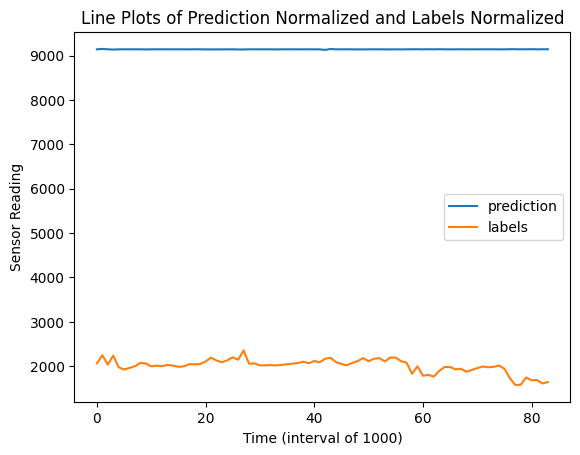

In [119]:
def graph():
    plt.plot(prediction_df['prediction'], label='prediction')
    plt.plot(prediction_df['labels'], label='labels')
    plt.xlabel('Time (interval of 1000)')
    plt.ylabel('Sensor Reading')
    plt.title('Line Plots of Prediction Normalized and Labels Normalized')
    plt.legend()
    plt.show()
graph()

one epoch

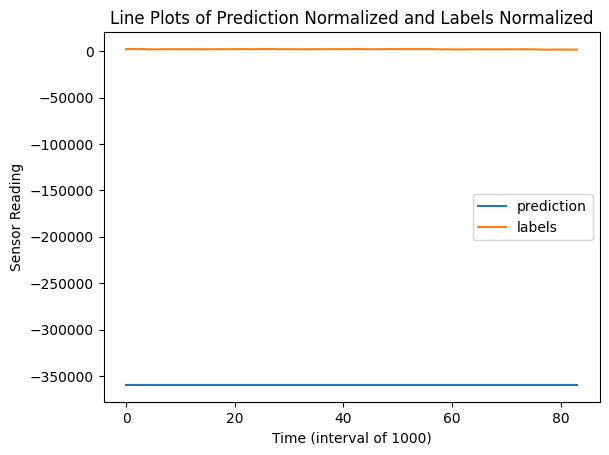

In [125]:
graph()